In [3]:
! pip install yfinance
import yfinance as yf


import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set(color_codes = True, rc = {'figure.figsize': (12,4)})
sns.set_palette(sns.color_palette("muted"))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
! pip install giotto-tda

import gtda.time_series as ts
import gtda.diagrams as diag
import gtda.homology as hl
import gtda.graphs as gr 
from gtda.plotting import plot_diagram, plot_point_cloud
from gtda.pipeline import Pipeline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Loading Data**

In [7]:
SP500 = yf.Ticker("^GSPC")
sp500_df = SP500.history(period = "max")
sp500_df.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1950-01-03,16.66,16.66,16.66,16.66,1260000,0,0
1950-01-04,16.85,16.85,16.85,16.85,1890000,0,0
1950-01-05,16.93,16.93,16.93,16.93,2550000,0,0
1950-01-06,16.98,16.98,16.98,16.98,2010000,0,0
1950-01-09,17.08,17.08,17.08,17.08,2520000,0,0


In [8]:
sp500_df.shape

(18272, 7)

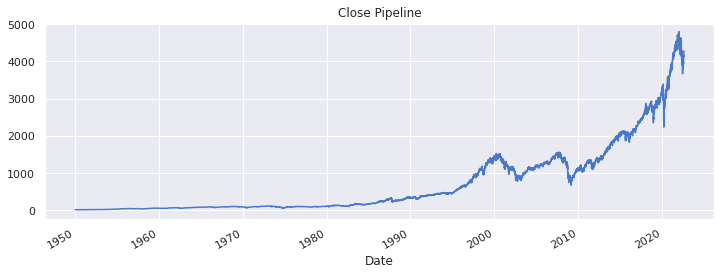

In [9]:
## Close Price Values Plot

price_df = sp500_df["Close"]
price_df.plot()
plt.title("Close Pipeline")
plt.show()

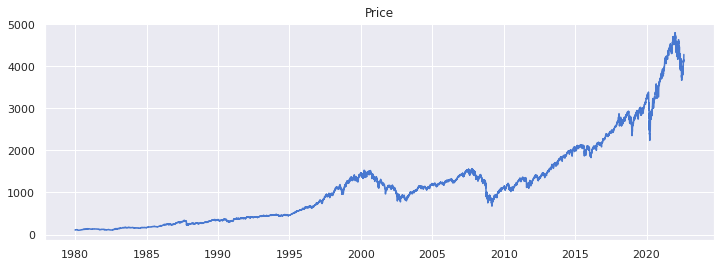

In [11]:
start_year = "1980"
price_resampled_df = price_df.resample("24H").pad()[start_year:]
plt.plot(price_resampled_df)
plt.title('Price')
plt.show()

In [12]:
embedding_dimension = 3
embedding_time_delay = 2

In [15]:
embedder = ts.SingleTakensEmbedding(
    parameters_type="fixed",
    dimension=embedding_dimension,
    time_delay=embedding_time_delay,
    n_jobs=-1,
)

In [16]:
price_values = price_resampled_df.values
price_embedded = embedder.fit_transform(price_values)

embedder_time_delay = embedder.time_delay_
embedder_dimension = embedder.dimension_

In [17]:
window_size = 31
window_stride = 4

In [18]:
sliding_window = ts.SlidingWindow(size=window_size, stride=window_stride)
price_embedded_windows = sliding_window.fit_transform(price_embedded)

In [19]:
window_num = 42
point_cloud = price_embedded_windows[window_num][:, :3]
plot_point_cloud(point_cloud)

## Simple Baseline

In [20]:
window_size_price = window_size + embedder_dimension * embedder_time_delay - 2
sliding_window_price = ts.SlidingWindow(size=window_size_price, stride=window_stride)
window_indices = sliding_window_price.slice_windows(price_values)
price_windows = sliding_window_price.fit_transform(price_values)

In [21]:
abs_derivative_of_means = np.abs(np.mean(np.diff(price_windows, axis=0), axis=1))

In [22]:
# define time index to combine with numpy arrays
indices = [win[1] - 1 for win in window_indices[1:]]
time_index_derivs = price_resampled_df.iloc[indices].index

In [23]:
resampled_close_price_derivs = price_resampled_df.loc[time_index_derivs]

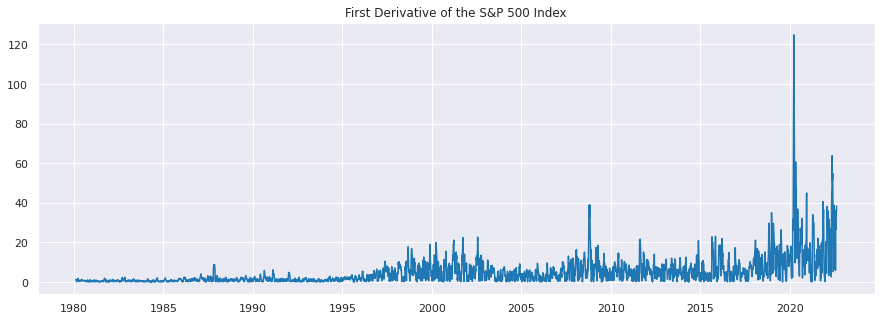

In [25]:
plt.figure(figsize=(15,5))
plt.plot(time_index_derivs, abs_derivative_of_means, color='#1f77b4')
plt.title('First Derivative of the S&P 500 Index')
plt.show()

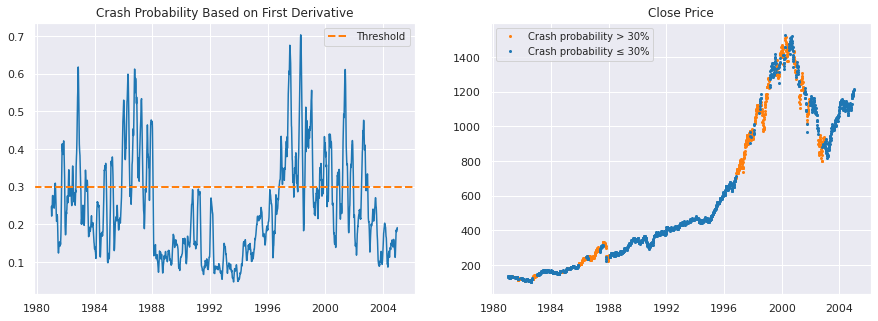

In [27]:
plot_crash_detections(
    start_date="1981-01-01",
    end_date="2005-01-01",
    threshold=0.3,
    distances=abs_derivative_of_means,
    time_index_derivs=time_index_derivs,
    price_resampled_derivs=resampled_close_price_derivs,
    metric_name='First Derivative'
)

In [26]:
def plot_crash_detections(
    start_date,
    end_date,
    threshold,
    distances,
    time_index_derivs,
    price_resampled_derivs,
    metric_name
):

    # calculate rolling mean, min, max of homological derivatives
    rolled_mean_h = pd.Series(distances).rolling(20, min_periods=1).mean()
    rolled_min_h = (
        pd.Series(distances)
        .rolling(len(distances), min_periods=1)
        .min()
    )
    rolled_max_h = (
        pd.Series(distances)
        .rolling(len(distances), min_periods=1)
        .max()
    )

    # normalise the time series values to lies within [0, 1]
    probability_of_crash_h = (rolled_mean_h - rolled_min_h) / (
        rolled_max_h - rolled_min_h
    )

    # define time intervals to plots
    is_date_in_interval = (time_index_derivs > pd.Timestamp(start_date)) & (
        time_index_derivs < pd.Timestamp(end_date)
    )
    probability_of_crash_h_region = probability_of_crash_h[is_date_in_interval]
    time_index_region = time_index_derivs[is_date_in_interval]
    resampled_close_price_region = price_resampled_derivs.loc[is_date_in_interval]

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(time_index_region, probability_of_crash_h_region, color="#1f77b4")
    plt.axhline(y=threshold, linewidth=2, color='#ff7f0e', linestyle='--', label='Threshold')
    plt.title(f"Crash Probability Based on {metric_name}")
    plt.legend(loc="best", prop={"size": 10},)

    plt.subplot(1, 2, 2)
    plt.plot(
        resampled_close_price_region[probability_of_crash_h_region.values > threshold],
        '#ff7f0e', marker='.', linestyle='None', markersize=4
    )
    plt.plot(
        resampled_close_price_region[probability_of_crash_h_region.values <= threshold],
        color="#1f77b4", marker='.', linestyle='None', markersize=4
    )

    plt.title("Close Price")
    plt.legend(
        [
            "Crash probability > {0}%".format(int(threshold * 100)),
            "Crash probability ≤ {0}%".format(int(threshold * 100)),
        ],
        loc="best",
        prop={"size": 10},
    )
    plt.show()
    
    
def plot_crash_comparisons(
    start_date,
    end_date,
    threshold,
    distances_1,
    distances_2,
    time_index_derivs,
    price_resampled_derivs,
):

    # calculate rolling mean, min, max of homological derivatives
    rolled_mean_1 = pd.Series(distances_1).rolling(20, min_periods=1).mean()
    rolled_min_1 = (
        pd.Series(distances_1)
        .rolling(len(distances_1), min_periods=1)
        .min()
    )
    rolled_max_1 = (
        pd.Series(distances_1)
        .rolling(len(distances_1), min_periods=1)
        .max()
    )

    # normalise the time series values to lies within [0, 1]
    probability_of_crash_1 = (rolled_mean_1 - rolled_min_1) / (
        rolled_max_1 - rolled_min_1
    )
    
    # calculate rolling mean, min, max of homological derivatives
    rolled_mean_2 = pd.Series(distances_2).rolling(20, min_periods=1).mean()
    rolled_min_2 = (
        pd.Series(distances_2)
        .rolling(len(distances_2), min_periods=1)
        .min()
    )
    rolled_max_2 = (
        pd.Series(distances_2)
        .rolling(len(distances_2), min_periods=1)
        .max()
    )

    # normalise the time series values to lies within [0, 1]
    probability_of_crash_2 = (rolled_mean_2 - rolled_min_2) / (
        rolled_max_2 - rolled_min_2
    )

    # define time intervals to plots
    is_date_in_interval = (time_index_derivs > pd.Timestamp(start_date)) & (
        time_index_derivs < pd.Timestamp(end_date)
    )
    probability_of_crash_1_region = probability_of_crash_1[is_date_in_interval]
    probability_of_crash_2_region = probability_of_crash_2[is_date_in_interval]

    time_index_region = time_index_derivs[is_date_in_interval]
    resampled_close_price_region = price_resampled_derivs.loc[is_date_in_interval]

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(
        resampled_close_price_region[probability_of_crash_1_region.values > threshold],
        '#ff7f0e', marker='.', linestyle='None', markersize=4
    )
    plt.plot(
        resampled_close_price_region[probability_of_crash_1_region.values <= threshold],
        "#1f77b4", marker='.', linestyle='None', markersize=4
    )

    plt.title("Baseline Detector")
    plt.ylabel('Close Price', fontsize=12)
    plt.legend(
        [
            "Crash probability > {0}%".format(int(threshold * 100)),
            "Crash probability ≤ {0}%".format(int(threshold * 100)),
        ],
        loc="best",
        prop={"size": 10},
    )

    plt.subplot(1, 2, 2)
    plt.plot(
        resampled_close_price_region[probability_of_crash_2_region.values > threshold],
        '#ff7f0e', marker='.', linestyle='None', markersize=4
    )
    plt.plot(
        resampled_close_price_region[probability_of_crash_2_region.values <= threshold],
        "#1f77b4", marker='.', linestyle='None', markersize=4
    )

    plt.title('Topological Detector')
    plt.legend(
        [
            "Crash probability > {0}%".format(int(threshold * 100)),
            "Crash probability ≤ {0}%".format(int(threshold * 100)),
        ],
        loc="best",
        prop={"size": 10},
    )
    plt.show()

## Persistence Diagrams

In [28]:
# define the number of homology dimensions to track
homology_dimensions = (0, 1)
VR = hl.VietorisRipsPersistence(homology_dimensions=homology_dimensions, n_jobs=-1)
diagrams = VR.fit_transform(price_embedded_windows)

In [29]:
VR.plot(diagrams, sample=window_num)

In [30]:
from joblib import Parallel, delayed, effective_n_jobs

from sklearn.utils import gen_even_slices
from sklearn.utils.validation import check_is_fitted

from gtda.diagrams import PairwiseDistance
from gtda.diagrams._metrics import _parallel_pairwise, landscapes, betti_curves
from gtda.diagrams._utils import _subdiagrams
from gtda.utils.validation import check_diagrams


class HomologicalDerivative(PairwiseDistance):
    def __init__(self, **kw_args):
        super().__init__(**kw_args)

    def _derivatives_generic(self, X, s):

        return np.array(
            [
                _parallel_pairwise(
                    np.expand_dims(X[t + 1], axis=0),
                    np.expand_dims(X[t], axis=0),
                    self.metric,
                    self.effective_metric_params_,
                    self.homology_dimensions_,
                    self.n_jobs,
                )[0, 0]
                for t in range(s.start, s.stop, 1)
            ]
        )

    def _derivatives(self, subdiagrams, kind, dim, params):
        n_samples, n_points = subdiagrams.shape[:2]
        if kind == "landscape":
            n_layers = min(params["n_layers"], n_points)
            features = landscapes(subdiagrams, params["samplings"][dim], n_layers)
        elif kind == "betti":
            features = betti_curves(subdiagrams, params["samplings"][dim])
        features = (features[1:] - features[:-1]).reshape(n_samples - 1, -1)
        features = np.linalg.norm(features, axis=1, ord=params["p"])

        return (params["step_sizes"][dim] ** (1 / params["p"])) * features

    def fit(self, X, y=None):
        super().fit(X, y)

        return self

    def transform(self, X, y=None):
        check_is_fitted(self, ["effective_metric_params_", "homology_dimensions_"])
        X = check_diagrams(X)

        if self.metric in ["landscape", "betti"]:
            Xt = Parallel(n_jobs=self.n_jobs)(
                delayed(self._derivatives)(
                    _subdiagrams(X[s.start : s.stop + 1], [dim], remove_dim=True),
                    self.metric,
                    dim,
                    self.effective_metric_params_,
                )
                for dim in self.homology_dimensions_
                for s in gen_even_slices(len(X) - 1, effective_n_jobs(self.n_jobs))
            )
            Xt = np.concatenate(Xt)
            Xt = Xt.reshape(len(self.homology_dimensions_), len(X) - 1).T
        else:
            Xt = Parallel(n_jobs=self.n_jobs)(
                delayed(self._derivatives_generic)(X, s)
                for s in gen_even_slices(len(X) - 1, effective_n_jobs(self.n_jobs))
            )
            Xt = np.concatenate(Xt)

        if self.order is not None:
            Xt = np.linalg.norm(Xt, axis=1, ord=self.order)

        return Xt

## Landscape distance

In [31]:
metric_params = {"p": 2, "n_layers": 10, "n_bins": 1000}

landscape_hom_der = HomologicalDerivative(
    metric="landscape", metric_params=metric_params, order=2, n_jobs=-1
)
landscape_succ_dists = landscape_hom_der.fit_transform(diagrams)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



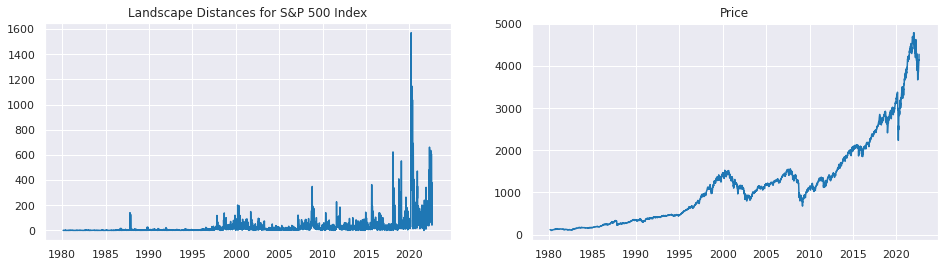

In [32]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(time_index_derivs, landscape_succ_dists, color="#1f77b4")
plt.title("Landscape Distances for S&P 500 Index")

plt.subplot(1, 2, 2)
plt.plot(resampled_close_price_derivs, "#1f77b4")
plt.title("Price")
plt.show()

## Betti Curves

In [33]:
metric_params = {"p": 2, "n_bins": 1000}


bettiHomDer = HomologicalDerivative(
    metric='betti', metric_params=metric_params, order=2, n_jobs=-1
)
betti_succ_dists = bettiHomDer.fit_transform(diagrams)

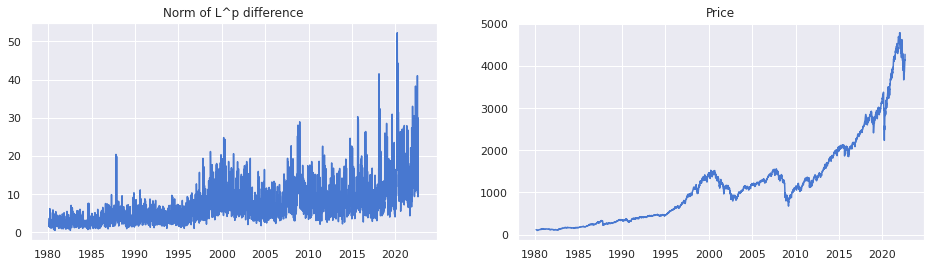

In [34]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(time_index_derivs, betti_succ_dists)
plt.title('Norm of L^p difference')

plt.subplot(1, 2, 2)
plt.plot(resampled_close_price_derivs)
plt.title('Price')
plt.show()

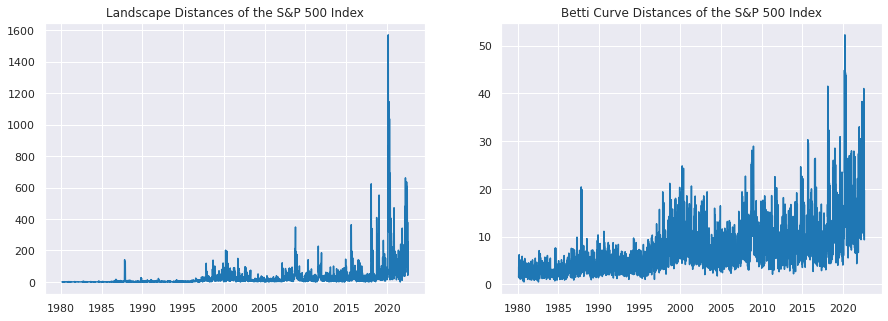

In [36]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(time_index_derivs, landscape_succ_dists, "#1f77b4")
plt.title("Landscape Distances of the S&P 500 Index")

plt.subplot(1, 2, 2)
plt.plot(time_index_derivs, betti_succ_dists, "#1f77b4")
plt.title('Betti Curve Distances of the S&P 500 Index')
plt.show()

## Topological Indicators for crashes

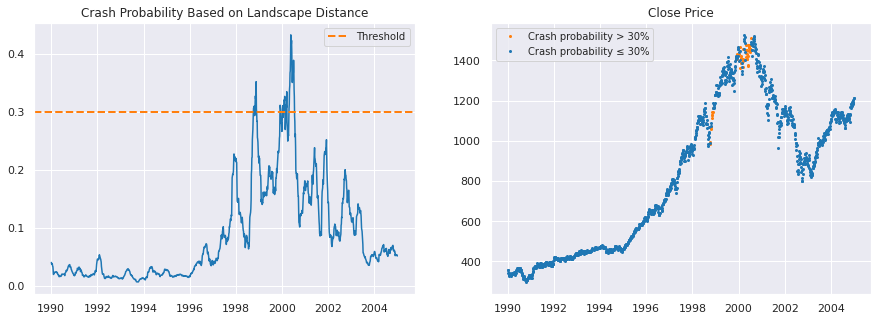

In [37]:
plot_crash_detections(
    start_date="1990-01-01",
    end_date="2005-01-01",
    threshold=0.3,
    distances=landscape_succ_dists,
    time_index_derivs=time_index_derivs,
    price_resampled_derivs=resampled_close_price_derivs,
    metric_name='Landscape Distance'
)

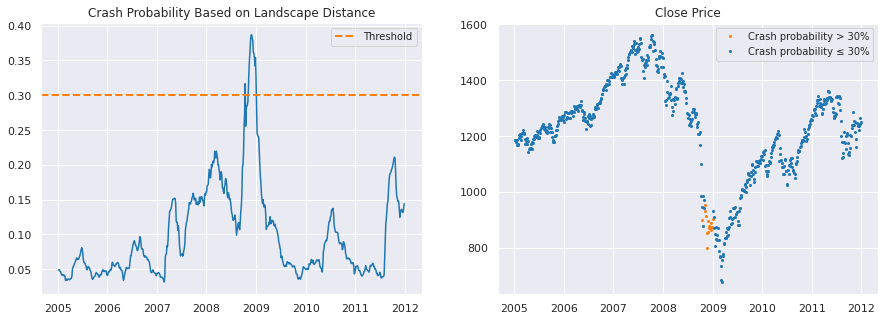

In [38]:
plot_crash_detections(
    start_date="2005-01-01",
    end_date="2012-01-01",
    threshold=0.3,
    distances=landscape_succ_dists,
    time_index_derivs=time_index_derivs,
    price_resampled_derivs=resampled_close_price_derivs,
    metric_name='Landscape Distance'
)

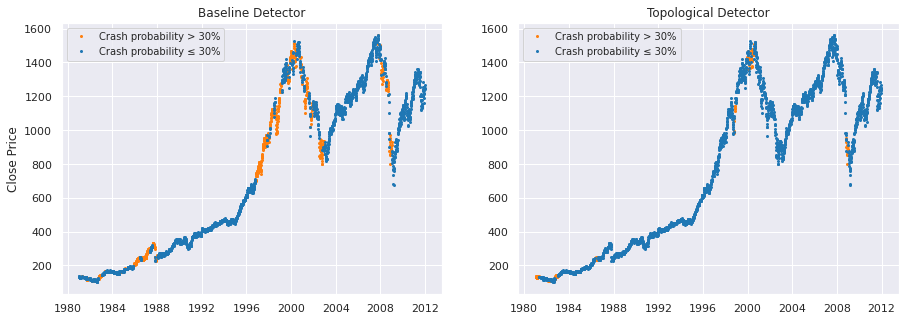

In [39]:
plot_crash_comparisons(
    start_date="1981-01-01",
    end_date="2012-01-01",
    threshold=0.3,
    distances_1=abs_derivative_of_means,
    distances_2=landscape_succ_dists,
    time_index_derivs=time_index_derivs,
    price_resampled_derivs=resampled_close_price_derivs,
)